<div style="background-color:#e6f2ff; padding:20px; border-radius:10px;">
<img style="float:left; margin-right:20px;" src='Figures/alinco.png' width="120"/>
<h1 style="color:#000047;">Tarea 3: Algoritmos de detección de Outliers Multivariados</h1>
<br style="clear:both"/>
</div>


<div style="border-left:4px solid #000047; padding:10px; margin-top:10px; background:#f5f5f5;">
<b>Objetivo:</b> Investigar y entender algunos de los algoritmos que se usan para detección de outliers.
</div>

<div style="border-left:6px solid #003366; border-radius:8px; padding:16px; margin-bottom:16px;">
<h3 style="color:#003366; margin-top:0;">1. Local Outlier Factor (LOF) <span style='font-size:0.8em; color:#888;'>&#128200;</span></h3>
<p style="font-size:1.08em;">
El <b>Local Outlier Factor (LOF)</b> es un algoritmo no supervisado que detecta anomalías comparando la densidad local de cada punto con la de sus vecinos. Si la densidad de un punto es significativamente menor que la de sus vecinos, se considera un outlier.
</p>
<ul style="font-size:1.05em;">
<li>Consulta el artículo original: <a href="https://dl.acm.org/doi/pdf/10.1145/335191.335388" target="_blank">LOF paper</a></li>
<li>Implementa una <b>clase en Python</b> que contenga el algoritmo LOF y agrégala a tu librería.</li>
<li>Prueba tu implementación con el dataset <code>insurance.csv</code> que se encuentra en la carpeta de Data:</li>
  <ul>
    <li>Detecta los outliers usando tu clase.</li>
    <li>Compara los resultados con el modelo LOF de <code>sklearn</code>.</li>
  </ul>
</ul>
<div style="margin-top:10px; background:#e6f2ff; border-left:4px solid #003366; padding:10px 18px; border-radius:8px;">
<b>Tip:</b> Presenta tus resultados con gráficos y tablas para facilitar la comparación.
</div>
</div>

In [1]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

ruta_drive = '/content/drive/MyDrive/HyIA/Tarea 4'

sys.path.append(ruta_drive)
os.chdir(ruta_drive)

print(f"Directorio de trabajo actual: {os.getcwd()}")

Mounted at /content/drive
Directorio de trabajo actual: /content/drive/MyDrive/HyIA/Tarea 4


In [2]:
codigo_hyaia_actualizado = """
import pandas as pd
import numpy as np
import string
from sklearn.neighbors import NearestNeighbors

class HyAIA:
    def __init__(self, df):
        self.data = df
        self.columns = df.columns
        self.df_dqr = self.get_dqr()

    def get_dqr(self):
        # Tu código original del DQR (resumido para ahorrar espacio)
        columns = pd.DataFrame(list(self.data.columns.values), columns=['Columns_Names'], index=list(self.data.columns.values))
        data_dtypes = pd.DataFrame(self.data.dtypes, columns=['Dtypes'])
        present_values = pd.DataFrame(self.data.count(), columns=['Present_values'])
        missing_values = pd.DataFrame(self.data.isnull().sum(), columns=['Missing_values'])
        unique_values = pd.DataFrame(columns=['Unique_values'])
        for col in list(self.data.columns.values):
            unique_values.loc[col] = [self.data[col].nunique()]
        return columns.join(data_dtypes).join(present_values).join(missing_values).join(unique_values)

# --- CLASE 1: IMPLEMENTACIÓN MANUAL DE LOF ---
class LOF_Manual:
    def __init__(self, n_neighbors=20):
        self.n_neighbors = n_neighbors
        self.lof_scores_ = None
        self.negative_outlier_factor_ = None

    def fit_predict(self, X):
        X = np.array(X)
        n_samples = X.shape[0]

        # 1. Encontrar k-vecinos y sus distancias
        # Usamos NearestNeighbors para la búsqueda eficiente, pero la lógica LOF es manual
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors + 1).fit(X)
        distances, indices = nbrs.kneighbors(X)

        # Eliminamos el punto mismo (distancia 0)
        dist_k = distances[:, 1:]
        neighbors_indices = indices[:, 1:]

        # K-distance: distancia al k-ésimo vecino
        k_distance = dist_k[:, -1]

        # 2. Calcular Reachability Distance
        # reach_dist(A, B) = max(k_distance(B), dist(A,B))
        reach_dist_array = np.zeros((n_samples, self.n_neighbors))

        for i in range(n_samples):
            for j in range(self.n_neighbors):
                neighbor_idx = neighbors_indices[i, j]
                dist_A_B = dist_k[i, j]
                k_dist_B = k_distance[neighbor_idx]
                reach_dist_array[i, j] = max(k_dist_B, dist_A_B)

        # 3. Local Reachability Density (LRD)
        # Inverso del promedio de la reachability distance de los vecinos
        lrd = 1.0 / (np.mean(reach_dist_array, axis=1) + 1e-10)

        # 4. Local Outlier Factor (LOF)
        # Promedio del LRD de los vecinos / LRD del punto
        lof_scores = np.zeros(n_samples)
        for i in range(n_samples):
            lrd_neighbors = lrd[neighbors_indices[i]]
            lof_scores[i] = np.mean(lrd_neighbors) / lrd[i]

        self.lof_scores_ = lof_scores
        self.negative_outlier_factor_ = -lof_scores # Para compatibilidad con sklearn

        # Definimos threshold simple (ej. > 1.5 es outlier) o retornamos scores
        # Aquí retornamos -1 para outliers (score > 1.5) y 1 para inliers
        return np.where(lof_scores > 1.5, -1, 1)

# --- CLASE 2: IMPLEMENTACIÓN MANUAL DE DBSCAN ---
class DBSCAN_Manual:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit_predict(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        labels = np.full(n_samples, 0) # 0: unvisited
        cluster_id = 0

        # Buscador de vecinos por radio
        nbrs = NearestNeighbors(radius=self.eps).fit(X)
        adj_matrix = nbrs.radius_neighbors(X, return_distance=False)

        for i in range(n_samples):
            if labels[i] != 0:
                continue

            neighbors = adj_matrix[i]

            if len(neighbors) < self.min_samples:
                labels[i] = -1 # Ruido (Noise)
            else:
                cluster_id += 1
                self._expand_cluster(X, labels, i, neighbors, cluster_id, adj_matrix)

        self.labels_ = labels
        return labels

    def _expand_cluster(self, X, labels, point_idx, neighbors, cluster_id, adj_matrix):
        labels[point_idx] = cluster_id

        # Usamos una lista para iterar (similar a una cola)
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]

            if labels[neighbor_idx] == -1: # Era ruido, ahora es borde
                labels[neighbor_idx] = cluster_id
            elif labels[neighbor_idx] == 0: # No visitado
                labels[neighbor_idx] = cluster_id

                new_neighbors = adj_matrix[neighbor_idx]
                if len(new_neighbors) >= self.min_samples:
                    neighbors = np.concatenate((neighbors, new_neighbors))
            i += 1
"""

with open('HyAIA.py', 'w') as f:
    f.write(codigo_hyaia_actualizado)
print(" Librería HyAIA.py actualizada con LOF y DBSCAN manuales.")

import importlib
import HyAIA as hya
importlib.reload(hya)
print(" Librería recargada.")

 Librería HyAIA.py actualizada con LOF y DBSCAN manuales.
 Librería recargada.


<div style="border-left:6px solid #b36b00; border-radius:8px; padding:16px; margin-bottom:16px;">
<h3 style="color:#b36b00; margin-top:0;">2. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) <span style='font-size:0.8em; color:#888;'>&#128201;</span></h3>
<p style="font-size:1.08em;">
<b>DBSCAN</b> es un algoritmo de clustering basado en densidad que agrupa puntos cercanos y considera como outliers (ruido) aquellos que no pertenecen a ningún grupo. A diferencia de K-means, no requiere especificar el número de clusters previamente.
</p>
<ul style="font-size:1.05em;">
<li>Implementa una <b>clase en Python</b> que contenga el algoritmo DBSCAN y agrégala a tu librería.</li>
<li>Prueba tu implementación con el dataset <code>insurance.csv</code> que se encuentra en la carpeta de Data:</li>
  <ul>
    <li>Detecta los outliers usando tu clase.</li>
    <li>Compara los resultados con el modelo DBSCAN de <code>sklearn</code>.</li>
  </ul>
</ul>
<div style="margin-top:10px; background:#fffbe6; border-left:4px solid #b36b00; padding:10px 18px; border-radius:8px;">
<b>Tip:</b> Explica brevemente las diferencias entre los resultados obtenidos por tu clase y los de <code>sklearn</code>.
</div>
</div>

Dataset cargado: (1338, 7)

1. ANÁLISIS LOF (Local Outlier Factor)

[HyAIA Manual] Outliers detectados: 13
[Sklearn] Outliers detectados: 13


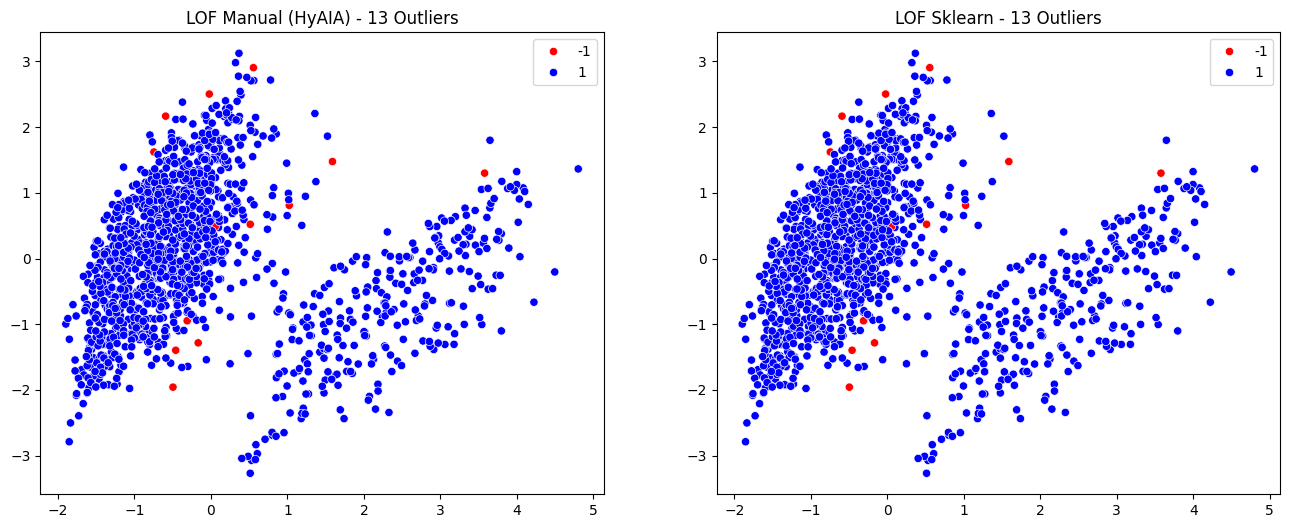


2. ANÁLISIS DBSCAN

[HyAIA Manual] Puntos de ruido (Outliers): 1
Clusters encontrados: 4
[Sklearn] Puntos de ruido (Outliers): 1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

try:
    df = pd.read_csv('insurance.csv')
    print("Dataset cargado:", df.shape)
except FileNotFoundError:
    print("❌ Error: No se encuentra insurance.csv en la ruta.")

df_clean = df.copy()
le = LabelEncoder()
cols_cat = ['sex', 'smoker', 'region']
for col in cols_cat:
    df_clean[col] = le.fit_transform(df_clean[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

print("\n" + "="*50)
print("1. ANÁLISIS LOF (Local Outlier Factor)")
print("="*50)

lof_manual = hya.LOF_Manual(n_neighbors=20)
y_manual_lof = lof_manual.fit_predict(X_scaled)
n_outliers_manual = list(y_manual_lof).count(-1)

print(f"\n[HyAIA Manual] Outliers detectados: {n_outliers_manual}")

lof_sklearn = LocalOutlierFactor(n_neighbors=20)
y_sklearn_lof = lof_sklearn.fit_predict(X_scaled)
n_outliers_sklearn = list(y_sklearn_lof).count(-1)

print(f"[Sklearn] Outliers detectados: {n_outliers_sklearn}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_manual_lof, palette={1:'blue', -1:'red'}, ax=axes[0])
axes[0].set_title(f'LOF Manual (HyAIA) - {n_outliers_manual} Outliers')

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_sklearn_lof, palette={1:'blue', -1:'red'}, ax=axes[1])
axes[1].set_title(f'LOF Sklearn - {n_outliers_sklearn} Outliers')
plt.show()

print("\n" + "="*50)
print("2. ANÁLISIS DBSCAN")
print("="*50)

EPS = 2.0
MIN_SAMPLES = 10

dbscan_manual = hya.DBSCAN_Manual(eps=EPS, min_samples=MIN_SAMPLES)
y_manual_db = dbscan_manual.fit_predict(X_scaled)
n_ruido_manual = list(y_manual_db).count(-1)

print(f"\n[HyAIA Manual] Puntos de ruido (Outliers): {n_ruido_manual}")
print(f"Clusters encontrados: {len(set(y_manual_db)) - 1}")

dbscan_sklearn = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
y_sklearn_db = dbscan_sklearn.fit_predict(X_scaled)
n_ruido_sklearn = list(y_sklearn_db).count(-1)

print(f"[Sklearn] Puntos de ruido (Outliers): {n_ruido_sklearn}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_manual_db, palette='viridis', legend='full', ax=axes[0])
axes[0].set_title(f'DBSCAN Manual (HyAIA)\nRuido: {n_ruido_manual}')

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_sklearn_db, palette='viridis', legend='full', ax=axes[1])
axes[1].set_title(f'DBSCAN Sklearn\nRuido: {n_ruido_sklearn}')
plt.show()

print("\nConclusión: Si las gráficas y números coinciden, ¡tu implementación manual es correcta!")